In [12]:
from L1_DifferentialEvolution import extract_data, model, diff_evolution
from scipy.optimize import Bounds
from scipy.optimize import minimize
from NelderMead_rounded import rounded_nelder_mead
from losses_bayesian import Losses
from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import math
import physics
import numpy as np
import matplotlib.pyplot as plt

frequency, intensity = extract_data() # extracting the desired information

# compressor parameters - obtained as minus the stretcher one - TO BE FIXED WITH REAL ONES ONCE THEY ARE AVAILABLE
COMPRESSOR = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
# non linearity parameter
B = 2
# cutoff frequencies, in THz, used to remove noise - derived from visual inspection
CUTOFF = (289.95, 291.91)
# model instantiation
l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF, num_points=int(5e3))

losses = Losses(l1_pump)

bounds_DE = Bounds(
            # GDD         # TOD          # FOD
    lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
    ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
)

bounds_matrix = np.vstack((bounds_DE.lb, bounds_DE.ub)).T
disp_bounds = np.sort(l1_pump.translate_control(bounds_matrix, verse = "to_disp"))

In [13]:
import numpy as np

def gaussian_kernel(X1, X2, length_scale=1.0):
    """
    Gaussian kernel function for multiple parameters using NumPy.
    """
    dist = np.linalg.norm((X1[:, None] - X2) / length_scale, axis=2)
    return np.exp(-0.5 * dist**2)

def expected_improvement(X, model_mean, model_std, best_value, xi=0.01):
    """
    Expected Improvement acquisition function for multiple parameters using NumPy.
    """
    mean = model_mean(X)
    std = model_std(X)
    z = (mean - best_value - xi) / std
    return (mean - best_value - xi) * norm_cdf(z) + std * norm_pdf(z)

def norm_pdf(x):
    """
    Normal probability density function using NumPy.
    """
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

def norm_cdf(x):
    """
    Normal cumulative density function approximation using the erf approximation.
    """
    return 0.5 * (1 + erf_approx(x / np.sqrt(2)))

def erf_approx(x):
    """Approximation to the error function using a polynomial expansion."""
    # Constants for the approximation
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    p = 0.3275911

    # Save the sign of x
    sign = np.sign(x)
    x = np.abs(x)

    # Approximation formula
    t = 1.0 / (1.0 + p * x)
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * np.exp(-x**2)

    return sign * y

def gaussian_process_predict(X_train, y_train, X_test, length_scale=1.0, noise=1e-10):
    """
    Gaussian process prediction using NumPy.
    """
    # Kernel matrices
    K = gaussian_kernel(X_train, X_train, length_scale) + noise * np.eye(len(X_train))
    K_s = gaussian_kernel(X_train, X_test, length_scale)
    K_ss = gaussian_kernel(X_test, X_test, length_scale) + noise * np.eye(len(X_test))

    # Compute the inverse of K
    K_inv = np.linalg.inv(K)

    # Mean prediction
    mu_s = K_s.T @ K_inv @ y_train

    # Variance prediction
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    std_s = np.sqrt(np.diag(cov_s))

    return mu_s, std_s

def bayesian_optimization(objective, bounds, n_iter=10, xi=0.02, decimal_precision1=5, decimal_precision2=6, decimal_precision3=7):
    """
    Bayesian optimization using Gaussian Processes for multiple parameters, implemented with NumPy.
    """
    noise = 0
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(200, len(bounds)))
    X[:, 0] = np.round(X[:, 0], decimals=decimal_precision1) * (1 + noise * (np.random.randn(1, 200) - 0.5))
    X[:, 1] = np.round(X[:, 1], decimals=decimal_precision2) * (1 + noise * (np.random.randn(1, 200) - 0.5))
    X[:, 2] = np.round(X[:, 2], decimals=decimal_precision3) * (1 + noise * (np.random.randn(1, 200) - 0.5))
    y = np.array([objective(x) for x in X])

    for _ in range(n_iter):
        # Predict using Gaussian Process
        mean, std = gaussian_process_predict(X, y, X, length_scale=1.0)

        # Compute the expected improvement
        new_points = np.linspace(bounds[:, 0], bounds[:, 1], num=5000)
        EI_values = expected_improvement(new_points, lambda x: gaussian_process_predict(X, y, x, length_scale=1.0)[0],
                                         lambda x: gaussian_process_predict(X, y, x, length_scale=1.0)[1], np.max(y), xi)

        # Select the next point to sample
        next_idx = np.argmax(EI_values)
        next_x = new_points[next_idx]
        next_x = next_x.flatten()

        # Sample the objective function at the next point
        next_x[0] = np.round(next_x[0], decimals=decimal_precision1) * (1 + noise * (np.random.randn(1) - 0.5))
        next_x[1] = np.round(next_x[1], decimals=decimal_precision2) * (1 + noise * (np.random.randn(1) - 0.5))
        next_x[2] = np.round(next_x[2], decimals=decimal_precision3) * (1 + noise * (np.random.randn(1) - 0.5))
        next_y = objective(next_x)

        # Update the datasets
        X = np.vstack([X, next_x])
        y = np.append(y, next_y)
        best_idx = np.argmax(y)
        print(y[best_idx])

    # Return the best configuration and its corresponding objective value
    best_idx = np.argmax(y)
    best_configuration = X[best_idx]
    best_objective = y[best_idx]

    return best_configuration, best_objective


In [14]:
# Define the bounds
bounds = np.array(((-5.31305788e-01, -4.17101926e-01), (-3.14772231e+08, 3.01620182e+08), (-2.55151879e+15, 1.56859005e+15)))

# Perform Bayesian Optimization
best_configuration, best_objective = bayesian_optimization(losses.lossb, bounds, n_iter=1, xi=0.02, decimal_precision1 = 5, decimal_precision2 = -2, decimal_precision3 = -3)

print(f"Best Configuration: {best_configuration}")
print(f"Best Objective Value: {best_objective}")

-32.24521333743943
Best Configuration: [-4.71110000e-01 -4.50047000e+07  1.05577304e+14]
Best Objective Value: -32.24521333743943


In [15]:
# Define the bounds
bounds = np.array(((-5.31305788e-01, -4.17101926e-01), (-3.14772231e+08, 3.01620182e+08), (-2.55151879e+15, 1.56859005e+15)))

# Take out of Bayesian optimization as startig point
random_values = best_configuration

# set print progress flag
print_progress = 1
# Run the optimization using Nelder-Mead method
optimized_solution, min_function_value, nfev, success, termination_reason, num_iterations, optimized_solutions = rounded_nelder_mead(losses.loss3, random_values, bounds, print_progress, decimal_precision1 = 3, decimal_precision2 = -5, decimal_precision3 = -13, maxiter=100)

# Print the results
print("Optimized Solution:", optimized_solution)
print("Minimum Function Value:", min_function_value)
print("Number of Function Evaluations", nfev)
print("Success:", success)
print("Termination Reason:", termination_reason)
print("Number of Iterations:", num_iterations)

iteration: 1
best value of objective function so far: 32.117002827222414
best candidate: [-4.71110000e-01 -4.50047000e+07  1.56859005e+15]
iteration: 2
best value of objective function so far: 32.117002827222414
best candidate: [-4.71110000e-01 -4.50047000e+07  1.56859005e+15]
iteration: 3
best value of objective function so far: 32.117002827222414
best candidate: [-4.71110000e-01 -4.50047000e+07  1.56859005e+15]
iteration: 4
best value of objective function so far: 32.117002827222414
best candidate: [-4.71110000e-01 -4.50047000e+07  1.56859005e+15]
iteration: 5
best value of objective function so far: 32.117002827222414
best candidate: [-4.71110000e-01 -4.50047000e+07  1.56859005e+15]
iteration: 6
best value of objective function so far: 32.117002827222414
best candidate: [-4.71110000e-01 -4.50047000e+07  1.56859005e+15]
iteration: 7
best value of objective function so far: 22.119850985623266
best candidate: [-4.77e-01  7.30e+06  8.30e+14]
iteration: 8
best value of objective function

iteration: 74
best value of objective function so far: 3.28679232133943
best candidate: [-4.75e-01 -7.80e+06  8.70e+14]
iteration: 75
best value of objective function so far: 3.28679232133943
best candidate: [-4.75e-01 -7.80e+06  8.70e+14]
iteration: 76
best value of objective function so far: 3.28679232133943
best candidate: [-4.75e-01 -7.80e+06  8.70e+14]
iteration: 77
best value of objective function so far: 3.28679232133943
best candidate: [-4.75e-01 -7.80e+06  8.70e+14]
iteration: 78
best value of objective function so far: 3.28679232133943
best candidate: [-4.75e-01 -7.80e+06  8.70e+14]
iteration: 79
best value of objective function so far: 3.28679232133943
best candidate: [-4.75e-01 -7.80e+06  8.70e+14]
iteration: 80
best value of objective function so far: 3.28679232133943
best candidate: [-4.75e-01 -7.80e+06  8.70e+14]
iteration: 81
best value of objective function so far: 3.28679232133943
best candidate: [-4.75e-01 -7.80e+06  8.70e+14]
iteration: 82
best value of objective fu

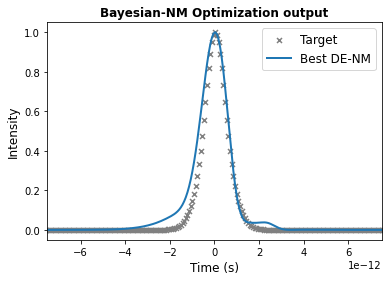

In [17]:
time, profile = l1_pump.forward_pass(optimized_solution)
fig, ax = plt.subplots()

ax.set_title("Bayesian-NM Optimization output", fontweight = "bold")
ax.scatter(losses.target_time, losses.target_profile, marker = "x", c = "grey", s = 25, label = "Target")
ax.plot(losses.target_time, np.roll(profile, - np.argmax(profile) + np.argmax(losses.target_profile)), label = "Best DE-NM", lw = 2)

ax.set_xlim(-7.5e-12, 7.5e-12); ax.set_xlabel("Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)
ax.legend(fontsize = 12)
plt.show()